In [1]:
import os

import pandas as pd
import torch
from torchvision import datasets , transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from src.models.cnn import CNN
from src.utility.generate_images import makeSyntheticTrain
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Data Transformation

In [2]:
# transformation to the image dataseet:
transforms_minimal = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)

transforms_basic = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.RandomHorizontalFlip(p=0.5),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)

transforms_auto = v2.Compose(
    [
        transforms.ToTensor(),
        v2.Grayscale(num_output_channels=1),
        v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET),
        v2.Resize((128, 128))  # Resize to a fixed size
    ]
)

#### Train Model

In [ ]:
def train_model(
        train_dir,
        test_dir,
        train_perc,
        synthetic_perc,
        transform,
        transform_name
):
    # load images
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Split the dataset into training and validation sets (80-20 split)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize the model
    model = CNN(in_channels=1, num_classes=4)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # train model
    best_val_loss = float('inf')
    patience = 2  # Number of epochs to wait for improvement before stopping
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []
    num_epochs=10

    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_corrects.double() / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth') # Save the model
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break
        
    # store results in dataframe
    dat = {
        "train_percentage":[train_perc]*len(val_losses),
        "synthetic_percentage":[synthetic_perc]*len(val_losses),
        "transform":transform_name,
        "epoch": range(len(val_losses)),
        "val_losses": val_losses,
        "train_losses": train_losses,
        "val_accuracies": [acc.item() for acc in val_accuracies]
    }

    result_df = pd.DataFrame(data=dat)

    return result_df

In [ ]:
train_dir = "data/alzheimer_mri/train"
test_dir = "data/alzheimer_mri/test"
synthetic_dir = "data/alzheimer_mri/synthetic_train"
n_sims = 100

df_all_results = pd.DataFrame(columns = [
    "sim_num","train_percentage","synthetic_percentage","transform",
    "epoch","val_losses","train_losses","val_accuracies"
])

for train_perc, synthetic_perc in zip(
    [0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0],
    [0.0, 0.6, 0.0, 0.4, 0.0, 0.2, 0.0, 0.2]
    ):

    for transform, transform_name in zip(
        [transforms_minimal, transforms_basic, transforms_auto],
        ['minimal','basic','auto']
        ):
        
            for n in range(n_sims):
                
                # make synthetic + real mix
                makeSyntheticTrain(train_dir, synthetic_dir, train_perc, synthetic_perc)
                
                df_sim_results = train_model(
                    train_dir = train_dir,
                    test_dir = synthetic_dir,
                    train_perc = train_perc,
                    synthetic_perc = synthetic_perc,
                    transform = transform,
                    transform_name = transform_name
                )

                df_sim_results["sim_num"] = n

                df_all_results = pd.concat([df_all_results, df_sim_results],ignore_index=True)

    df_all_results.to_csv(f"results/sim_results_train{str(train_perc*10).replace('.','')}_synth{str(synthetic_perc*10).replace('.','')}.csv")

In [3]:
df_results = pd.DataFrame()
for f in os.listdir('results/'):
    df_results = pd.concat((df_results,pd.read_csv(f'results/{f}')))

In [4]:
df_results['category'] = df_results['transform'] + '_' + df_results['train_percentage'].astype(str) + '_' +  df_results['synthetic_percentage'].astype(str)

In [ ]:
df_results[df_results['category'].isin(['minimal_0.4_0.6','minimal_0.6_0.0','minimal_0.8_0.0'])]

<Axes: xlabel='epoch', ylabel='val_losses'>

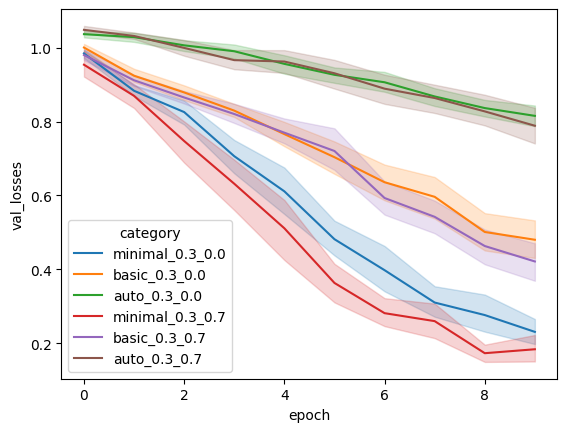

In [30]:
import seaborn as sns
sns.lineplot(
    data=df_results[df_results['category'].str.contains('0.3')],
    x='epoch',
    y='val_losses',
    hue='category'
)

<Axes: xlabel='epoch', ylabel='val_losses'>

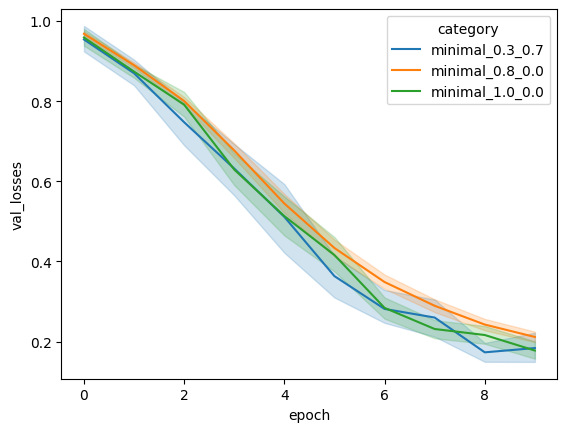

In [55]:
import seaborn as sns
transform_category = 'minimal'
sns.lineplot(
    data=df_results[
        df_results['category'].isin(
            [
                'minimal_1.0_0.0',
                'minimal_0.8_0.0',
                'minimal_0.3_0.7',
            ])],
    x='epoch',
    y='val_losses',
    hue='category'
)

<Axes: xlabel='epoch', ylabel='val_losses'>

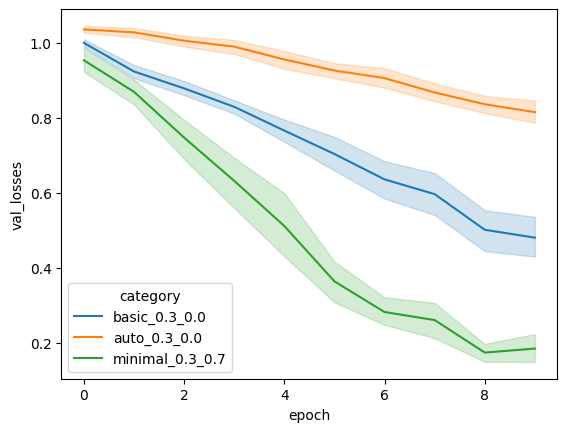

In [38]:
sns.lineplot(
    data=df_results[
        df_results['category'].isin(
            [
                'minimal_0.3_0.7',   
                'auto_0.3_0.0',
                'basic_0.3_0.0',
            ])],
    x='epoch',
    y='val_losses',
    hue='category'
)

In [33]:
df_example = df_results[df_results['category'].isin([f'{transform_category}_1.0_0.0',f'{transform_category}_0.3_0.7',f'{transform_category}_0.3_0.0'])]
df_example.groupby(['category','epoch']).median(numeric_only=True)

Unnamed: 0  sim_num  train_percentage  \
category        epoch                                          
minimal_0.3_0.0 0           631.0      4.5               0.3   
                1           632.0      4.5               0.3   
                2           633.0      4.5               0.3   
                3           634.0      4.5               0.3   
                4           635.0      4.5               0.3   
                5           636.0      4.5               0.3   
                6           637.0      4.5               0.3   
                7           638.0      4.5               0.3   
                8           639.0      4.5               0.3   
                9           640.0      4.5               0.3   
minimal_0.3_0.7 0           925.0      4.5               0.3   
                1           926.0      4.5               0.3   
                2           927.0      4.5               0.3   
                3           928.0      4.5               0.3   
                4           929.0      4.5               0.3   
                5           930.0      4.5               0.3   
                6           931.0      4.5               0.3   
                7           932.0      4.5               0.3   
                8           933.0      4.5               0.3   
                9           934.0      4.5               0.3   
minimal_1.0_0.0 0          1796.0      4.5               1.0   
                1          1797.0      4.5               1.0   
                2          1798.0      4.5               1.0   
                3          1799.0      4.5               1.0   
                4          1800.0      4.5               1.0   
                5          1801.0      4.5               1.0   
                6          1802.0      4.5               1.0   
                7          1803.0      4.5               1.0   
                8          1804.0      4.5               1.0   
                9          1805.0      4.5               1.0   

                       synthetic_percentage  val_losses  train_losses  \
category        epoch                                                   
minimal_0.3_0.0 0                       0.0    0.993223      1.045024   
                1                       0.0    0.867338      0.930459   
                2                       0.0    0.811314      0.841939   
                3                       0.0    0.695896      0.701936   
                4                       0.0    0.606316      0.536793   
                5                       0.0    0.456649      0.361156   
                6                       0.0    0.335983      0.262121   
                7                       0.0    0.291080      0.145738   
                8                       0.0    0.242017      0.080480   
                9                       0.0    0.219863      0.053806   
minimal_0.3_0.7 0                       0.7    0.939761      1.032308   
                1                       0.7    0.870914      0.899931   
                2                       0.7    0.738901      0.799199   
                3                       0.7    0.656659      0.650597   
                4                       0.7    0.505183      0.473669   
                5                       0.7    0.358775      0.301265   
                6                       0.7    0.269964      0.192551   
                7                       0.7    0.261481      0.112926   
                8                       0.7    0.177659      0.072716   
                9                       0.7    0.174202      0.048649   
minimal_1.0_0.0 0                       0.0    0.963184      1.029365   
                1                       0.0    0.870483      0.909947   
                2                       0.0    0.798436      0.817789   
                3                       0.0    0.603093      0.672059   
                4                       0.0    0.480748      0.457293   
   

In [36]:
0.174202/0.219863-1

-0.2076793275812665